# Generate a PPi train + validation set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action) and a Y2H test set from [HuRI](http://www.interactome-atlas.org/download)
## prep

- March 2021 version of [APID](http://cicblade.dep.usal.es:8080/APID/init.action)
- interactomes for the 35 organisms listed as "with more than 500 interactions" only
- some organism datasets will be dropped later, so not fetching smaller sets is ok
- binary interactomes -> Level 2 -> `Q1` suffix
- not using *H. sapiens* for training -> `9606_*Q1.txt`


first number is number of IDs, second is number of PPIs

| APID     |              ISI |            noISI |      loss |
|---------:|:----------------:|:----------------:|:---------:|
| w/ Human | 67'240 : 319'429 | 61'429 : 296'653 | .09 : .07 |
| no Human | 55'014 : 179'349 | 45'026 : 161'598 | .18 : .10 |
|     loss |    .18 : .44     |    .27 : .46     | .33 : .49 |

In [1]:
from __future__ import annotations

import os
import sys
import shutil
import importlib

import numpy as np
from tqdm import tqdm
from pathlib import Path
from dataclasses import dataclass, field

import pandas as pd
from dataclass_wizard import JSONWizard

In [2]:
!which python
!pwd

/home/quirin/anaconda3/envs/ppi/bin/python
/home/quirin/PYTHON/ppi/data/ppi_dataset/template


In [3]:
# assert False, 'don\'t run'
# !mv apid.zip ../apid.zip
# !mv hi_union.psi ../hi_union.psi
# !ln ../apid.zip apid.zip
# !ln ../hi_union.psi hi_union.psi

In [3]:
cwd = Path.cwd()
package_root = str(cwd.parents[2])
if package_root not in sys.path:
    sys.path.append(package_root)

In [4]:
session = '7062'
session_dir = cwd.parent / 'results' / session

shutil.copytree(cwd, session_dir,
                symlinks=True, dirs_exist_ok=True)
os.chdir(session_dir.resolve())
!pwd

/home/quirin/PYTHON/ppi/data/ppi_dataset/results/7062


In [5]:
from data.utils import api, extract, general, pairs, plot, reduce, proteome

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

In [6]:

@dataclass
class Config(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    accept_homodimers: bool = False
    remote_rostclust: bool = True
    add_proteomes: bool = True

    ap: Path = Path('apid')
    hp: Path = Path('huri')
    qp: Path = None
    pp: Path = Path('swissprot')

    min_seq_len: int = 50
    max_seq_len: int = 1500

    psi_path = Path('hi_union.psi')
    hval_config: dict = field(default_factory=dict)
    hval_config_path: Path = Path('hval_config.json')

    seed: int = 42
    ratio: float = 10.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: Set[str] = field(default_factory=set)
    train_species: Set[str] = field(default_factory=set)

    val_raw_fasta: Path = ap / 'apid_validation_raw.fasta'
    val_raw_tsv: Path = ap / 'apid_validation_raw.tsv'
    val_rr_fasta: Path = ap / 'apid_validation_rr.fasta'
    val_rr_tsv: Path = ap / 'apid_validation_rr.tsv'
    val_c3_fasta: Path = ap / 'apid_validation_c3.fasta'
    val_fasta: Path = Path('apid_validation.fasta')
    val_tsv: Path = Path('apid_validation.tsv')

    test_raw_fasta: Path = hp / 'huri_test_raw.fasta'
    test_raw_tsv: Path = hp / 'huri_test_raw.tsv'
    test_rr_fasta: Path = hp / 'huri_test_rr.fasta'
    test_rr_tsv: Path = hp / 'huri_test_rr.tsv'
    test_c3_fasta: Path = hp / 'huri_test_c3.fasta'
    test_fasta: Path = Path('huri_test.fasta')
    test_tsv: Path = Path('huri_test.tsv')

    train_tsv: Path = Path('apid_train.tsv')
    train_fasta: Path = Path('apid_train.fasta')
    train_raw_fasta: Path = ap / 'apid_train_raw.fasta'
    train_raw_tsv: Path = ap / 'apid_train_raw.tsv'

    train_proteome: Path = Path('train_proteome.json')
    val_proteome: Path = Path('val_proteome.json')
    test_proteome: Path = Path('test_proteome.json')

    # results
    weird_species: set[int] = field(default_factory=set)
    train_bias: str = None
    train_seqs: int = None
    train_size: int = None
    test_seqs: int = None
    val_seqs: int = None
    val_bias: str = None
    val_size: int = None
    val_sizes: str = None
    test_bias: float = None
    test_size: int = None
    test_sizes: str = None


val_species = {10377, 37296, 9031, 8355, 9913, 7955, 39947, 10116}
hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

c = Config(hval_config=hval_config, val_species=val_species)

In [7]:
remote = Path('/home/k/kaindll') / Path(*session_dir.parts[4:])


def push():
    if c.remote_rostclust:
        !rsync -zar --size-only -e ssh "." "kaindll@lapislazuli:{remote}"


def pull():
    if c.remote_rostclust:
        !rsync -zar --size-only -e ssh "kaindll@lapislazuli:{remote}/" "."


c.remote_rostclust, remote

(True, PosixPath('/home/k/kaindll/ppi/data/ppi_dataset/results/7062'))

In [8]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

## Toy example
#### bias of negative dataset

In [ ]:
# demonstrate sampling strategies: toy PPI table example
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK'''
ppis = ppis_from_string(raw)
ppi_dict = dict()
ppis

In [ ]:
ppi_dict['balanced'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                               strategy=SamplingStrategy.BALANCED)
# balanced sampling tries to conserve the distribution of degrees -> high-bias dataset

In [ ]:
ppi_dict['random'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                             strategy=SamplingStrategy.RANDOM)
# random sampling gives a nearly un-biased dataset

In [ ]:
ppi_dict['complement'], *_ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                 strategy=SamplingStrategy.BALANCED)
# sampling the entire network complement will perfectly invert the degree distribution

#### strategies visualized
It becomes apparent that the combination of graph size and density is important, and that random or balanced sampling generate different sets of negatives.

In [ ]:
_ = draw_toy_ppis(ppis, ppi_dict)

#### with homodimers

In [ ]:
# added F-F
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK\nF\tF'''
ppis = ppis_from_string(raw)

In [ ]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                               strategy=SamplingStrategy.BALANCED)
ppi_dict['random'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                             strategy=SamplingStrategy.RANDOM)
ppi_dict['complement'], *_ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                 strategy=SamplingStrategy.BALANCED)
_ = draw_toy_ppis(ppis, ppi_dict)

#### input homodimers, but not allowed as negatives

In [ ]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                               strategy=SamplingStrategy.BALANCED,
                                               accept_homodimers=False)
ppi_dict['random'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                             strategy=SamplingStrategy.RANDOM,
                                             accept_homodimers=False)
ppi_dict['complement'], *_ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                 strategy=SamplingStrategy.BALANCED,
                                                 accept_homodimers=False)
_ = draw_toy_ppis(ppis, ppi_dict)

## Train set: APID
#### extract from `<taxid>*_Q1.txt` files

In [9]:
c.qp = unzip_apid(zip_path='apid.zip', keep_human=c.keep_human,
                  keep_interspecies=c.keep_interspecies)
c.qp

PosixPath('apid_q1')

In [10]:
uniprot_ids = extract_apid_uniprot_ids(c.qp)
len(uniprot_ids)

45026

In [11]:
ppis = extract_apid_ppis(c.qp)
len(ppis)

161598

In [12]:
ppis.head()

,UniprotID_A,UniprotID_B,species
0,Q28645,Q8SQG9,9986
1,P00489,Q00756,9986
2,B6CAM1,P42532,9986
3,P07293,P13806,9986
4,P07293,P19517,9986


#### interspecies interactions
Check if there are PPIs (based on UniProt IDs) that occur in several species. We use APID `noISI` data per default, so the exclusion of this data is not implemented.

In [13]:
find_multi_species_ppis = lambda ppi_df: pd.concat(
    [df for i, df in ppi_df.groupby(
        ['UniprotID_A', 'UniprotID_B']) if len(df) > 1]
    + [ppi_df.loc[ppi_df.species == 'is there a marsupilami?']])

find_multi_species_ppis(ppis)

,UniprotID_A,UniprotID_B,species


In [14]:
# proof that actually worked: add some dummy data
for i in [0, 1]:
    s = ppis.iloc[i].copy()
    s.species = 'marsupilami'
    ppis = pd.concat([ppis, pd.DataFrame(s).T], axis=0)

marsu = find_multi_species_ppis(ppis)

# drop the dummy data
ppis = ppis.loc[ppis.species != 'marsupilami']
marsu

,UniprotID_A,UniprotID_B,species
1,P00489,Q00756,9986
1,P00489,Q00756,marsupilami
0,Q28645,Q8SQG9,9986
0,Q28645,Q8SQG9,marsupilami


or more generally protein IDs that occur in several species:

In [15]:
find_multi_species_proteins(ppis)

,UniprotID,species


#### species lookup

In [16]:
# pick a charismatic animal for validation!
taxonomy = fetch_taxonomic_info(ppis.species)
taxonomy

100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


,species,name,speciesn_ppis
0,632,Yersinia pestis,6
1,1392,Bacillus anthracis,4
2,3702,Arabidopsis thaliana,44723
3,6239,Caenorhabditis elegans,15257
4,7227,Drosophila melanogaster,35493
5,7955,Danio rerio,124
6,8355,Xenopus laevis,49
7,9031,Gallus gallus,40
8,9913,Bos taurus,117
9,9986,Oryctolagus cuniculus,10


#### download sequences

In [ ]:
# skip if re-running this w/o changes above or deleting files
_ = uniprot_api_fetch(uniprot_ids, c.ap / 'apid')

#### download proteomes

In [ ]:
# skip if re-running this w/o changes above or deleting files
if c.add_proteomes:
    fetch_proteomes(set(taxonomy.species) | {9606}, c.pp)

#### map IDs to seq hashes

In [17]:
hash_ppis = ppis_to_hashes(ppis, c.ap / 'apid.json').drop_duplicates()
hash_ppis.head()

,hash_A,hash_B,species
0,CRC-E9B8AE168CDFB8C5,CRC-F496FAD64156BCED,9986
1,CRC-1CD9FB8F47890226,CRC-9884F06FDD3AE9D3,9986
2,CRC-148C462A8653A3E5,CRC-6E3725560658481B,9986
3,CRC-047B10D1946B0796,CRC-B00DE7F3C877B618,9986
4,CRC-047B10D1946B0796,CRC-629420640A7457CC,9986


In [18]:
len(ppis) - len(hash_ppis)

1030

In [19]:
fasta = SeqIO.to_dict(SeqIO.parse(c.ap / 'apid.hash.fasta', 'fasta'))
len(fasta)

44707

#### filter by seq length

In [20]:
c.min_seq_len, c.max_seq_len

(50, 1500)

dropped 9425/160568 PPIs from length filtering
dropped 0/42505 table IDs and 0/151143 rows, and 2202/44707 sequence IDs


(44707, 42505)

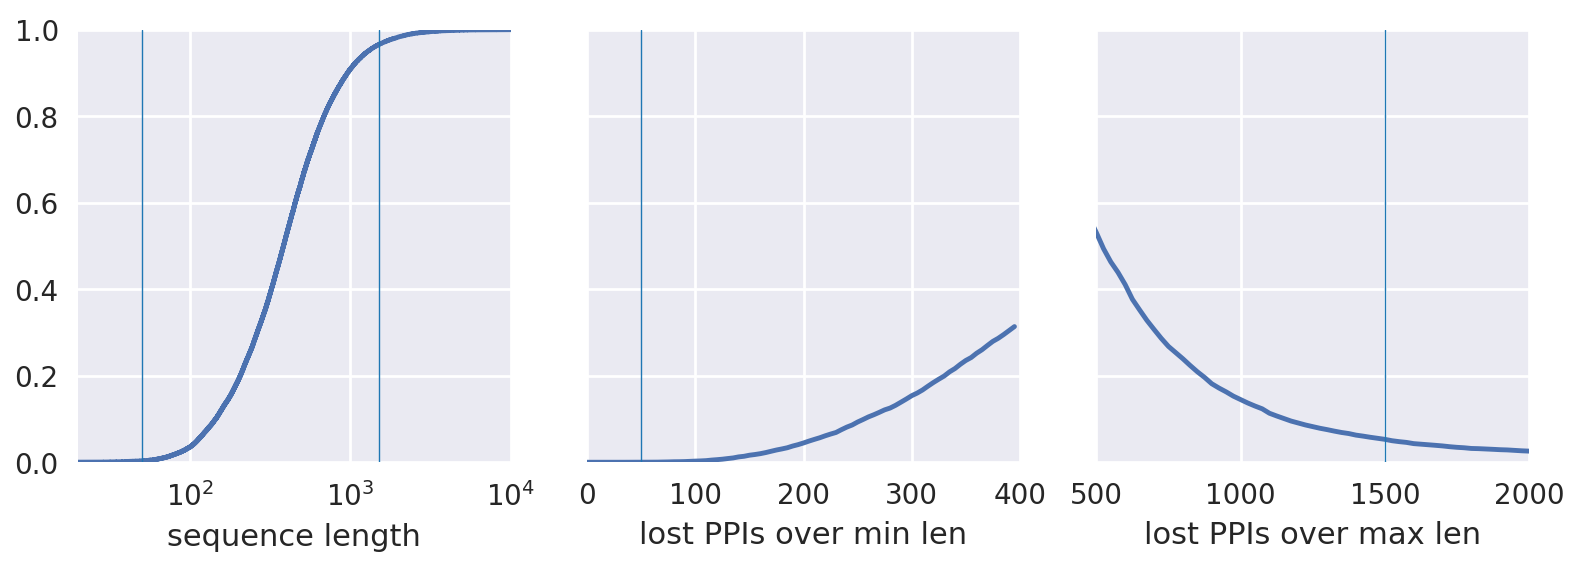

In [21]:
_hash_ppis, _fasta, fig = filter_ppis_and_fasta_by_len(
    hash_ppis, fasta, c.min_seq_len, c.max_seq_len)
len(fasta), len(_fasta)

continue if these limits were ok, or change/set the values for
`cfg.min_seq_len, cfg.max_seq_len` and re-run the filtering cell

In [22]:
hash_ppis = _hash_ppis
fasta = _fasta

In [ ]:
# skip if re-running this w/o changes above or deleting files
if c.add_proteomes:
    filter_proteomes_by_len(c.pp, c.min_seq_len, c.max_seq_len)

#### homodimer share
Overall count, share, overall PPI count

(False, 4249, 0.0281, 151143)

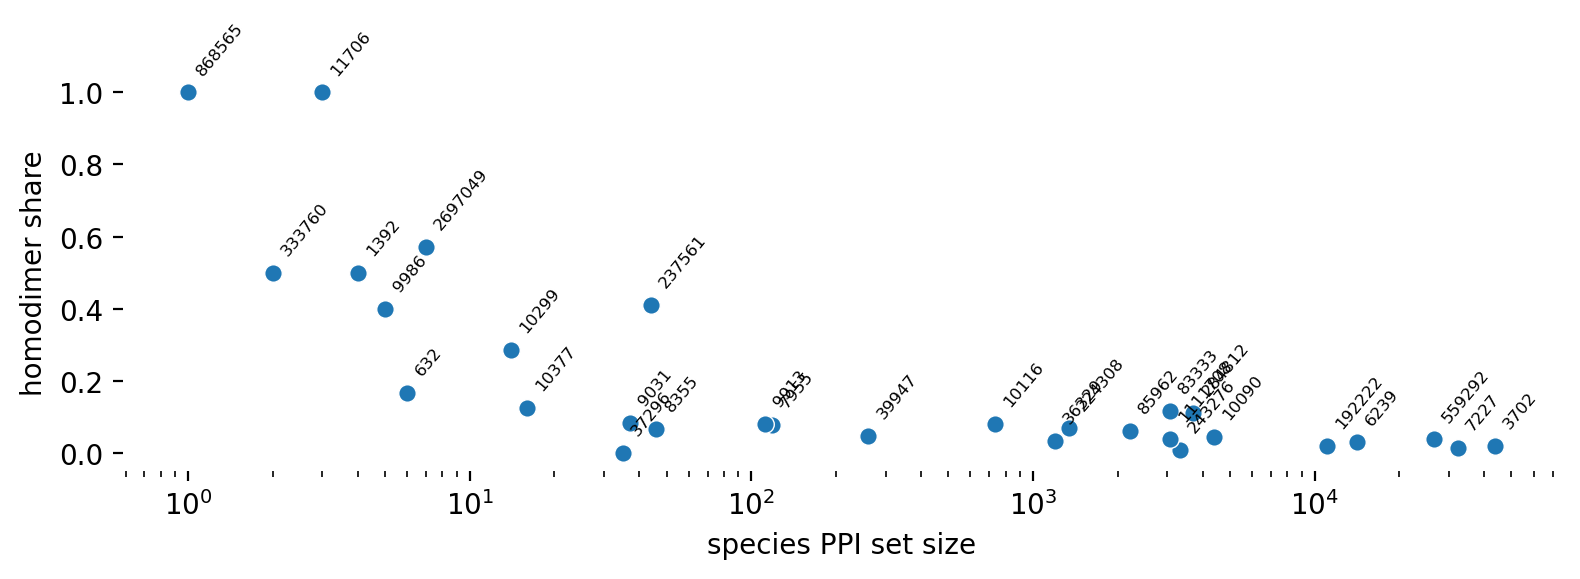

In [23]:
_ = plot_homodimer_share(hash_ppis)
c.accept_homodimers, *count_homodimers(hash_ppis),

In [24]:
if not c.accept_homodimers:
    hash_ppis = drop_homodimers(hash_ppis)
    hash_ppis, fasta = shrink_both_ways(hash_ppis, fasta)
len(hash_ppis), len(fasta)

dropped 0/42053 table IDs and 0/146894 rows, and 452/42505 sequence IDs


(146894, 42053)

## Validation set: APID
#### val: select species/proteins
Either by sampling a subset of proteins and selecting the PPIs or picking the ones for one or more particular species

In [25]:
c.val_set_size, c.val_species

(0.1, {7955, 8355, 9031, 9913, 10116, 10377, 37296, 39947})

In [26]:
hash_ppis['label'] = 1
if c.val_species is not None:
    train, val = make_validation_species(hash_ppis, c.val_species)
else:
    # if the set becomes too large, try another seed!
    # With this approach, PPIs *will* be lost
    train, val = make_validation_split(hash_ppis, c.val_set_size, c.seed)
    c.val_species = set(val.species)
c.train_species = set(train.species)
len(train), len(train) / len(hash_ppis), len(val), len(val) / len(hash_ppis)

(145635, 0.9914291938404564, 1151, 0.00783558212044059)

In [27]:
val.head()

,hash_A,hash_B,species,minlen,maxlen,label
0,CRC-62DAFEF75EB3549C,CRC-AA7025623F66321F,39947,602,660,1
1,CRC-739F14BA1BB5E0EA,CRC-78DB44C421A4C708,39947,249,262,1
2,CRC-483507B10661DF95,CRC-C233BD8328987CAE,39947,260,499,1
3,CRC-483507B10661DF95,CRC-F4094830FEF61600,39947,260,264,1
4,CRC-483507B10661DF95,CRC-617E676075DCE87E,39947,179,260,1


In [28]:
val.species.unique(), train.species.unique()

(array([39947, 10377,  9913, 10116,  8355, 37296,  7955,  9031]),
 array([   9986,   10090,  192222,  243276,    3702,    1392,   85962,
          36329,  224308,   83333,   10299,     632,  333760,    7227,
           6239,  559292, 2697049,  284812,  237561, 1111708]))

Separate the validation set sequences from the ones remaining as train set

#### train: save seqs + positives


In [29]:
_, train_seqs = shrink_both_ways(train.copy(), fasta.copy())
c.train_seqs = len(train_seqs)
len(train_seqs), len(fasta)

dropped 0/40833 table IDs and 0/145635 rows, and 1220/42053 sequence IDs


(40833, 42053)

In [30]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_raw_fasta, 'fasta')
train.to_csv(c.train_raw_tsv, sep='\t', header=True, index=False)
c.train_raw_fasta, c.train_raw_tsv

(PosixPath('apid/apid_train_raw.fasta'), PosixPath('apid/apid_train_raw.tsv'))

#### val: save seqs + positives

In [31]:
_, val_seqs = shrink_both_ways(val.copy(), fasta.copy())
len(val_seqs), len(fasta)

dropped 0/1197 table IDs and 0/1151 rows, and 40856/42053 sequence IDs


(1197, 42053)

In [32]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_raw_fasta, 'fasta')
val.to_csv(c.val_raw_tsv, sep='\t', header=True, index=False)
c.val_raw_fasta, c.val_raw_tsv

(PosixPath('apid/apid_validation_raw.fasta'),
 PosixPath('apid/apid_validation_raw.tsv'))

Mind that the TSVs will contain only positives! Sample negatives only after most of the `uniqueprot`-shebang.

## Test set: HuRI
#### download and extract PPIs

In [33]:
c.psi_path

PosixPath('hi_union.psi')

In [34]:
# it's somehow a lot faster to download this from a browser!
# or run !wget "http://www.interactome-atlas.org/data/HI-union.psi" -O "hi_union.psi"
download_y2h_interactome(c.psi_path)

already downloaded and SHA256 checks out


PosixPath('hi_union.psi')

In [37]:
huri_ppis, huri_seq_ids = extract_huri_ppis(c.psi_path)
len(huri_ppis)

97888

In [38]:
huri_seqs, _ = fetch_huri_seqs(huri_seq_ids, c.hp / 'huri')
len(huri_seqs)

loading from huri/huri.fasta and huri/huri.json


9119

#### map + filter PPIs

In [39]:
print(set(huri_ppis.species))  # only human, but keep the label
huri_ppis.head()

{9606}


,0,1,species
0,P0DP25,A0A087WXN0,9606
1,Q68D86-1,Q9HD26-2,9606
2,Q13515,Q9UJW9,9606
3,P30049,Q05519-2,9606
4,ENSP00000462298,P43220,9606


In [40]:
# some 35K protein IDs point to the same sequence
huri_hash_ppis = ppis_to_hashes(huri_ppis, c.hp / 'huri.json')
len(huri_ppis), len(huri_ppis) - len(huri_hash_ppis), len(huri_hash_ppis)

(97888, 35329, 62559)

In [41]:
# make sure we don't test on sequences that we trained on; A LOT more checks later
huri_hash_ppis = remove_ids_from(huri_hash_ppis, black_list_fasta=c.train_raw_fasta)
len(huri_hash_ppis)

61208

In [42]:
*count_homodimers(huri_hash_ppis), c.accept_homodimers

(752, 0.0123, 61208, False)

In [43]:
if not c.accept_homodimers:
    huri_hash_ppis = drop_homodimers(huri_hash_ppis)
    huri_hash_ppis, huri_seqs = shrink_both_ways(huri_hash_ppis, huri_seqs)
len(huri_hash_ppis), len(huri_seqs)

dropped 0/8953 table IDs and 0/60456 rows, and 166/9119 sequence IDs


(60456, 8953)

dropped 1205/60456 PPIs from length filtering
dropped 0/8773 table IDs and 0/59251 rows, and 180/8953 sequence IDs


(8953, 8773)

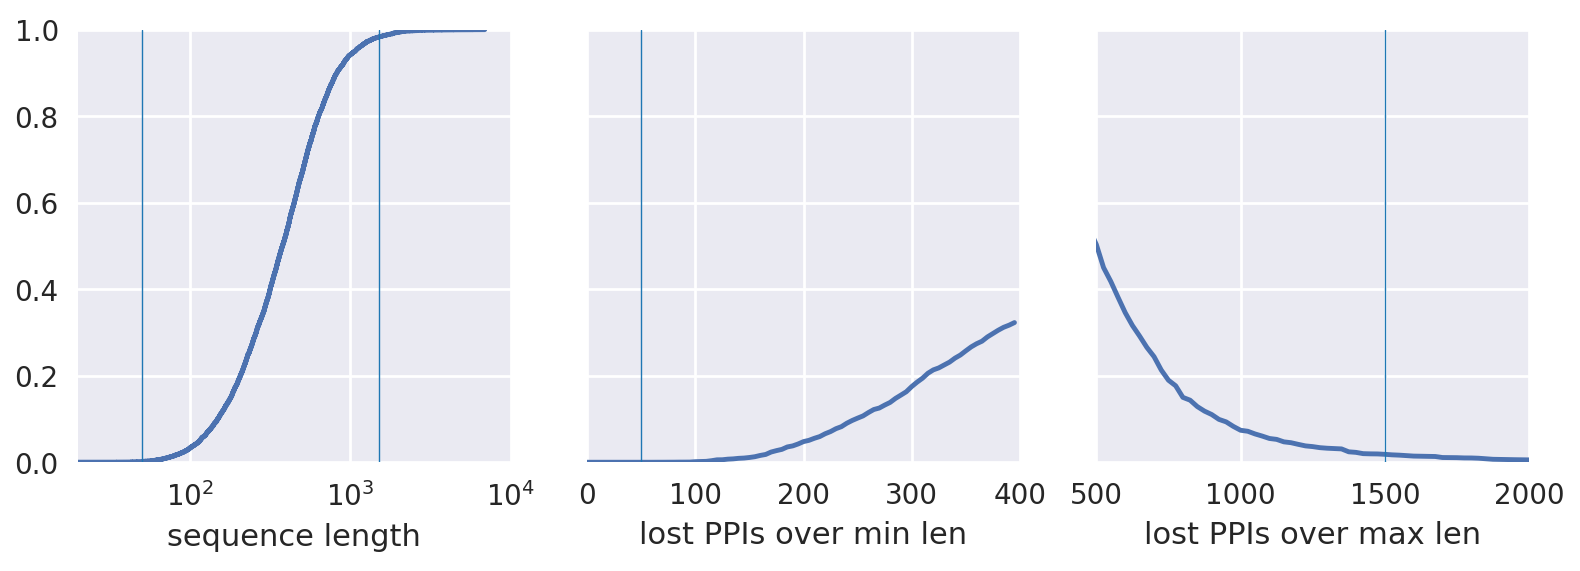

In [44]:
_huri_hash_ppis, _huri_seqs, fig = filter_ppis_and_fasta_by_len(
    huri_hash_ppis, huri_seqs, c.min_seq_len, c.max_seq_len)
len(huri_seqs), len(_huri_seqs)

#### test: save seqs + positives

In [45]:
huri_hash_ppis = _huri_hash_ppis
huri_seqs = _huri_seqs

In [46]:
_ = SeqIO.write(huri_seqs.values(), c.test_raw_fasta, 'fasta')
huri_hash_ppis.to_csv(c.test_raw_tsv, sep='\t', header=True, index=False)
c.test_raw_fasta, c.test_raw_tsv

(PosixPath('huri/huri_test_raw.fasta'), PosixPath('huri/huri_test_raw.tsv'))

## Test + validation: redundancy-reduce

Use [rostclust](https://git.rostlab.org/bernhoferm/mmseqs2-uniqueprot/-/tree/F_typer_app) to create non-redundant `test` and `validation` sets. <br> Don't run the next cells in the wrong order, and don't forget to copy the files back and forth if you are running `rostclust` elsewhere! <br>In particular, copy files after `shrink_files_both_ways`.

In [47]:
c.hval_config

{'shortAlignmentLen': 50,
 'longSeqLen': 180,
 'reduceRandomAlign': False,
 'clusterThreshold': 20}

The flag below allows me to test this notebook without the MMseqs2 runs. Leave `remote_rostclust` at `True` and copy the two result files to this folder; or run `rostclust uniqueprot[2D]` now and here.

In [53]:
c.remote_rostclust

True

In [53]:
push()

In [ ]:
# redundancy-reduce the test set
run_uniqueprot(c.test_raw_fasta, c.test_rr_fasta, c.hval_config, pretend=c.remote_rostclust)

In [ ]:
# and validation
run_uniqueprot(c.val_raw_fasta, c.val_rr_fasta, c.hval_config, pretend=c.remote_rostclust)

In [57]:
pull()

In [62]:
fastalen = lambda _file: len([r.id for r in SeqIO.parse(_file, 'fasta')])

In [59]:
# also drop PPIs accordingly
assert c.test_rr_fasta.is_file()
shrink_files_both_ways(c.test_raw_tsv, c.test_rr_fasta,
                       new_tsv_name=c.test_rr_tsv,
                       new_fasta_name=c.test_fasta)
c.test_seqs = fastalen(c.test_fasta)
assert c.val_rr_fasta.is_file()
shrink_files_both_ways(c.val_raw_tsv, c.val_rr_fasta,
                       new_tsv_name=c.val_rr_tsv,
                       new_fasta_name=c.val_fasta)
c.val_seqs = fastalen(c.val_fasta)

dropped 2864/8773 table IDs and 36101/59251 rows, and 771/5909 sequence IDs
dropped 364/1197 table IDs and 634/1151 rows, and 191/833 sequence IDs


In [60]:
push()

## Prepare proteomes

In [63]:
if not c.add_proteomes:
    raise NotImplementedError('Please manually skip ahead!')

#### run separately: faster
Separately clustering the proteomes against the test/validation set and then redundancy-reducing each one is faster and might lead to a more balanced combined proteome set that is better fit to sample from than merging all proteomes first and then running the two steps on huge files.

#### train: cluster against val
Mind that `train_species` and `val_species` may overlap! We deal with that later.

In [ ]:
rr_pattern_proteomes(c.train_species,
                     proteome_dir=c.pp, pattern='{sp}.fasta', prefix='val',
                     ref_fasta=c.val_fasta,
                     hval_config=hval_config, pretend=c.remote_rostclust)

#### train: cluster against test

In [ ]:
rr_pattern_proteomes(c.train_species,
                     proteome_dir=c.pp, pattern='{sp}_nr_val.fasta',
                     prefix='valtest', ref_fasta=c.test_fasta,
                     hval_config=hval_config, pretend=c.remote_rostclust)

In [ ]:
pull()

These `_nr_valtest.fasta` proteomes are now ready to be used as negatives for the train set!

#### val: cluster against val

In [ ]:
rr_pattern_proteomes(c.val_species, c.pp, '{sp}.fasta', 'val',
                     ref_fasta=c.val_fasta,
                     hval_config=hval_config, pretend=c.remote_rostclust)

#### val: redundancy-reduce

In [ ]:
rr_pattern_proteomes(c.val_species, c.pp, '{sp}_nr_val.fasta', 'val',
                     hval_config=hval_config, pretend=c.remote_rostclust)

#### val: merge

In [ ]:
pull()

In [70]:
val_concat = c.pp / 'val_proteome_concat.fasta'
merge_pattern_proteomes(c.val_species, val_concat, c.pp, '{sp}_rr_val.fasta')

In [ ]:
push()

#### val: redundancy-reduce merged set

In [71]:
val_concat_rr = val_concat.with_stem(val_concat.stem + '_rr')
run_uniqueprot(val_concat, val_concat_rr, hval_config, c.remote_rostclust)

'rostclust uniqueprot --hval-config-path hval_config.json swissprot/val_proteome_concat.fasta swissprot/val_proteome_concat_rr.fasta'

#### test: cluster against test

In [ ]:
run_uniqueprot2D(c.pp / '9606.fasta', c.test_fasta, c.pp / '9606_nr_test.fasta',
                 hval_config=hval_config, pretend=c.remote_rostclust)

#### test: redundancy-reduce

In [ ]:
run_uniqueprot(c.pp / '9606_nr_test.fasta', c.pp / '9606_rr_test.fasta',
               hval_config=hval_config, pretend=c.remote_rostclust)

The `proteomes/9606_rr_test.fasta` can be used as test set negatives directly; as this is a single-species set there is no combined set that needs redundancy reduction.

#### collate train/val/test proteomes
Create per-species dicts of potential negative interaction partners. Doing this once to save some `pull` calls.

In [ ]:
pull()

In [86]:
train_proteome = read_hash_proteomes(c.train_species, c.pp, '{sp}_nr_valtest.fasta')
with c.train_proteome.open('w') as json_file:
    json.dump(train_proteome, json_file, indent=2)

100%|██████████| 20/20 [00:33<00:00,  1.69s/it, batch=2.7e+6] 


In [74]:
val_proteome = parse_val_proteome(val_concat_rr)
with c.val_proteome.open('w') as json_file:
    json.dump(val_proteome, json_file, indent=2)

44912it [00:06, 7252.66it/s] 


In [75]:
test_proteome = read_hash_proteomes({9606}, c.pp, '{sp}_rr_test.fasta')
with c.test_proteome.open('w') as json_file:
    json.dump(test_proteome, json_file, indent=2)

100%|██████████| 1/1 [00:01<00:00,  1.63s/it, batch=9606]


In [77]:
push()

## Generate negatives
Negatives are sampled *per species*. Mind that the test set is human-only!
Re-write with proteomes, but without C123 labels.

#### APID train: generate negatives

In [48]:
# sanity check if there are any proteins in test that
# were already in train. re: "do not add back in identical ones"
assert not ({r.id for r in SeqIO.parse(c.train_raw_fasta, 'fasta')} & {
    r.id for r in SeqIO.parse(c.test_fasta, 'fasta')})

In [49]:
c.ratio, c.seed, c.strategy

(10.0, 42, <SamplingStrategy.BALANCED: 1>)

In [50]:
train_proteome = {int(k): v for k, v in json.load(c.train_proteome.open('r')).items()}

In [51]:
train

,hash_A,hash_B,species,minlen,maxlen,label
0,CRC-E9B8AE168CDFB8C5,CRC-F496FAD64156BCED,9986,316,551,1
1,CRC-1CD9FB8F47890226,CRC-9884F06FDD3AE9D3,9986,843,1109,1
7,CRC-5BE12DBB6C90FFCF,CRC-81FED9E732A0F902,9986,160,182,1
0,CRC-97F4A4FE4B248DDF,CRC-99C22E64412B6236,10090,217,579,1
1,CRC-D5C9B7275C34BCE0,CRC-F6B25929100CC1D9,10090,216,437,1
...,...,...,...,...,...,...
3143,CRC-7D2801E515DB444B,CRC-B0AF566AA258F13E,1111708,345,492,1
3144,CRC-4D10C738AF2F32B1,CRC-B0AF566AA258F13E,1111708,345,583,1
3145,CRC-75F8E28EB5EA9515,CRC-B0AF566AA258F13E,1111708,345,473,1
3146,CRC-67BBA62136E36D63,CRC-B0AF566AA258F13E,1111708,345,898,1


In [52]:
train.species.value_counts()

3702       42794
7227       31832
559292     25498
6239       13694
192222     10863
10090       4186
284812      3302
243276      3294
1111708     2944
83333       2707
85962       2068
224308      1247
36329       1156
237561        26
10299         10
632            5
2697049        3
9986           3
1392           2
333760         1
Name: species, dtype: int64

In [53]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

237561: 26 positives, aim for 260 negatives


237561: 550it [00:00, 6228.11it/s]             


245/260 in-network negatives
need 19 extra proteines; select 19 from 5164 available SwissProt proteins. Try to create 29 interactions, ideally 10.0 per protein.
got 274 negatives with bias 0.997


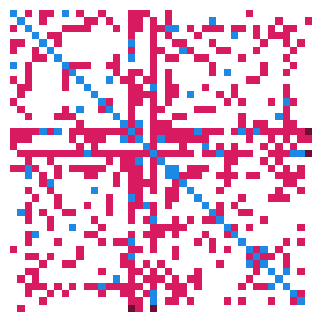

In [54]:
with mpl.rc_context({'figure.dpi': 100}):
    train_ppis, train_negs, train_bias, _ = make_train_negatives(
        train.loc[train.species == 237561].copy(),
        strategy=c.strategy, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=train_proteome)

In [55]:
train_negs

,hash_A,hash_B,label
0,CRC-063BD314C9755686,CRC-3F7DA56CCBAABA1F,0
1,CRC-063BD314C9755686,CRC-51C7E74B0AD30AAB,0
2,CRC-063BD314C9755686,CRC-55DAF24C27F4CA0A,0
3,CRC-063BD314C9755686,CRC-5EDFBB9B834E3478,0
4,CRC-063BD314C9755686,CRC-6C1209F89BD7A8F5,0
...,...,...,...
24,CRC-8256A2F177F761A0,CRC-1E86DAF57EDC7292,0
25,CRC-8256A2F177F761A0,CRC-81518A20CFBB7463,0
26,CRC-8256A2F177F761A0,CRC-3D6E67538522ADCF,0
27,CRC-8256A2F177F761A0,CRC-4F4B23405ED56BED,0


In [573]:
sp = 237561

true_ppis = train.loc[train.species == sp].copy()
strategy = SamplingStrategy.BALANCED
ratio = 10.0
seed = c.seed
sus_ppis = None
accept_homodimers = True  # c.accept_homodimers
sp_proteome = {sp: train_proteome[sp].copy()}

In [574]:
# map protein IDs to their sorting index
uniq_true = {_id: idx for idx, _id in enumerate(
    np.unique(true_ppis.iloc[:, [0, 1]]))}
uniq_neg = {idx: _id for _id, idx in uniq_true.items()}
indexize = np.vectorize(uniq_true.get)
unindex = np.vectorize(uniq_neg.get)
idx_ppis = indexize(true_ppis.iloc[:, [0, 1]])

if sus_ppis is not None:
    idx_ppis = np.vstack((idx_ppis, indexize(sus_ppis.iloc[:, [0, 1]])))

# np.unique returns sorted values, so this works out
proteins, counts = np.unique(true_ppis.iloc[:, [0, 1]], return_counts=True)
n = len(proteins)
vertices = np.array(range(n))
indices = np.array(range(n + 1))
len(idx_ppis)

26

In [575]:
sp = true_ppis.species[0]

rng = np.random.default_rng(seed=seed)

wants = np.floor(counts * ratio).astype(int)
if strategy.value != 1:
    wants = np.full_like(wants, np.floor(sum(counts) * ratio / n)).astype(int)

# make sure that wants is an integer vector and its sum as close to the target as possible
idcs = list(rng.choice(vertices, size=n, replace=True, p=counts / sum(counts)))
while np.round(sum(counts) * ratio) > sum(wants):
    idx = idcs.pop(0)
    wants[idx] += 1

wants = np.append(wants, 0)
limit = sum(wants)
limit

520

In [576]:
# initialize the matrix
mat = np.zeros((n + 1, n + 1), dtype=int)
if not accept_homodimers:
    np.fill_diagonal(mat, 1)
    mat[-1, -1] = 0
mat[idx_ppis[:, 0], idx_ppis[:, 1]] = 1
mat[idx_ppis[:, 1], idx_ppis[:, 0]] = 1

In [577]:
with tqdm(total=limit, position=0, desc=str(sp)) as pbar:
    while np.sum(wants[:n]):
        x = rng.choice(vertices, size=1, replace=True, p=wants[:n] / sum(wants[:n]))[0]
        wants[x] -= 1
        wants[-1] = max(0, 2 * wants[x] - (mat[x, :n] == 0) @ wants[:n])
        p_proteome = np.append((mat[x, :n] == 0) * wants[:n], wants[n])
        if not np.sum(p_proteome):
            p_proteome[-1] = 1
        y = rng.choice(indices, size=1, p=p_proteome / sum(p_proteome))[0]
        mat[y, x] -= 1  # tolerant against y=n
        if x != y:
            mat[x, y] -= 1
        wants[y] -= 1  # y=n will ignore this
        pbar.update(2)

237561: 548it [00:00, 8162.04it/s]             


In [578]:
np.min(mat)

-18

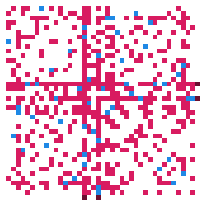

In [579]:
with mpl.rc_context({'figure.dpi': 64}):
    fig, ax = plt.subplots()
    cmap = mpl.colors.ListedColormap(-(np.min(mat) + 1) * ['#6B0E30']
                                     + ['#D81B60', '#FFFFFF', '#1E88E5'])
    heat = sns.heatmap(mat,  # annot=True, linewidth=.2,
                       ax=ax, cmap=cmap, cbar=False)
    ax.set(box_aspect=1, xticks=[], yticks=[])

In [580]:
mat.shape

(41, 41)

In [581]:
negs = np.vstack(np.nonzero(np.triu(mat, k=0) < 0)).T
negs = negs[(negs[:, 0] < n) & (negs[:, 1] < n)]  # filter out the last col
negatives = pd.DataFrame(unindex(negs))
negatives

,0,1
0,CRC-063BD314C9755686,CRC-230A832F5FF95210
1,CRC-063BD314C9755686,CRC-4A824993A13ECBF9
2,CRC-063BD314C9755686,CRC-51C7E74B0AD30AAB
3,CRC-063BD314C9755686,CRC-5EDFBB9B834E3478
4,CRC-063BD314C9755686,CRC-68E22227601A1060
...,...,...
241,CRC-D5281A9D3D2FB08C,CRC-EC070EC9E6501B52
242,CRC-D70EE099BE07C734,CRC-DFCAEB7AF84BD281
243,CRC-D70EE099BE07C734,CRC-EC070EC9E6501B52
244,CRC-E8C3527C172C69E9,CRC-FE6EAED0B3EACB97


In [536]:
elem, idcs, _ = np.unique(mat[:, n], return_counts=True, return_index=True)
extra = np.vstack((idcs, -elem)).T
extra = extra[extra[:, 1] > 0]
extra

array([[16,  5],
       [19,  1]])

In [537]:
min_extra = np.max(extra[:, 1])
extra_interactions = np.sum(extra[:, 1])
avg_extra = np.ceil(extra_interactions / ratio).astype(int)
available = len(sp_proteome[sp])
n_extra = min(available, max(min_extra, avg_extra))
sp, min_extra, n_extra, available, extra_interactions, ratio, avg_extra, extra

(237561,
 5,
 5,
 5164,
 6,
 7,
 1,
 array([[16,  5],
        [19,  1]]))

In [538]:
extra_proteins = list(rng.choice(list(sp_proteome[sp].keys()), size=n_extra, replace=False))
extra_proteins

['CRC-0380AE0B287D5A50',
 'CRC-33D150DD0728A8BF',
 'CRC-ED1A9DEF584D1EE9',
 'CRC-19F128C4B36401A7',
 'CRC-E01ADA817515B2FD']

In [539]:
extra_pairs = list()
for p_idx, n_partners in extra:
    p = uniq_neg[p_idx]
    partners = rng.choice(extra_proteins, size=min(n_partners, len(extra_proteins)), replace=False)
    extra_pairs.extend([(p, partner) for partner in partners])
extras = pd.DataFrame(extra_pairs)
extras

,0,1
0,CRC-777B4535B22EA81F,CRC-0380AE0B287D5A50
1,CRC-777B4535B22EA81F,CRC-19F128C4B36401A7
2,CRC-777B4535B22EA81F,CRC-E01ADA817515B2FD
3,CRC-777B4535B22EA81F,CRC-33D150DD0728A8BF
4,CRC-777B4535B22EA81F,CRC-ED1A9DEF584D1EE9
5,CRC-8256A2F177F761A0,CRC-E01ADA817515B2FD


In [540]:
extra_crcs = set(extras.iloc[:, 1])
extra_crcs

{'CRC-0380AE0B287D5A50',
 'CRC-19F128C4B36401A7',
 'CRC-33D150DD0728A8BF',
 'CRC-E01ADA817515B2FD',
 'CRC-ED1A9DEF584D1EE9'}

In [541]:
negatives = pd.concat((negatives, extras))
negatives

,0,1
0,CRC-063BD314C9755686,CRC-4A824993A13ECBF9
1,CRC-063BD314C9755686,CRC-5EDFBB9B834E3478
2,CRC-063BD314C9755686,CRC-68E22227601A1060
3,CRC-063BD314C9755686,CRC-777B4535B22EA81F
4,CRC-063BD314C9755686,CRC-7A9CF033CDEF170A
...,...,...
1,CRC-777B4535B22EA81F,CRC-19F128C4B36401A7
2,CRC-777B4535B22EA81F,CRC-E01ADA817515B2FD
3,CRC-777B4535B22EA81F,CRC-33D150DD0728A8BF
4,CRC-777B4535B22EA81F,CRC-ED1A9DEF584D1EE9


In [86]:
while np.sum(wants[:n]):
    break

In [77]:
x = rng.choice(vertices, size=1, replace=True, p=wants[:n] / sum(wants[:n]))[0]
x

4

In [78]:
wants[x] -= 1
wants[-1] = max(0, 2 * wants[x] - (mat[x, :n] == 0) @ wants[:n])
x, wants

(4, array([3, 3, 3, 3, 2, 3, 6, 3, 3, 0]))

In [84]:
p_proteome = np.append((mat[x, :n] == 0) * wants[:n], wants[n])
x, p_proteome

(4, array([3, 3, 3, 3, 0, 3, 0, 3, 3, 0]))

In [85]:
if not np.sum(p_proteome):
    p_proteome[-1] = 1
y = rng.choice(indices, size=1, p=p_proteome / sum(p_proteome))[0]
y

2

In [ ]:
train_ppis, train_negs, train_bias, _ = make_train_negatives(
    train, strategy=c.strategy, ratio=c.ratio, seed=c.seed,
    accept_homodimers=c.accept_homodimers, proteome=train_proteome)

In [ ]:
train_bias

In [83]:
train

,hash_A,hash_B,species,minlen,maxlen,label
0,CRC-022360ED7772EB60,CRC-511C305E5DE86727,7227,425,760,1
1,CRC-089B43434CA818C3,CRC-C645CF3B10C6701A,7227,248,1464,1
2,CRC-089B43434CA818C3,CRC-2C1562208547DA9C,7227,262,1464,1
3,CRC-089B43434CA818C3,CRC-3C69AD351E36B7DC,7227,679,1464,1
4,CRC-87F4DBB26CFE4E42,CRC-BD49C813DDB2A77D,7227,445,805,1
...,...,...,...,...,...,...
2704,CRC-A28833BCAF4F9D04,CRC-F16DC0BE1E8862C6,36329,874,1426,1
2710,CRC-78CF3EE38425D91A,CRC-B57B45443196D52F,36329,262,1140,1
2712,CRC-3DE86F4BCC20BAD6,CRC-F5D0C31C3816B0D9,36329,483,743,1
2723,CRC-78CF3EE38425D91A,CRC-85237FF035B94039,36329,262,435,1


In [ ]:
for p in [c.val_rr_tsv, c.val_c3_fasta, c.val_fasta]:
    assert p.is_file(), f'missing {p}'

In [ ]:
val_ppis, val_negatives, val_bias = make_test_negatives(
    c.val_rr_tsv, c.val_c3_fasta, c.val_fasta, c.strategy,
    c.ratio, c.seed, c.accept_homodimers, c.test_proteome)
c.val_bias = str(val_bias) if type(val_bias) == np.float64 else val_bias.to_json()
val_negatives.head()

In [ ]:
val_ppis.head()

## Test + validation: get C123 classes

#### cluster against train
First, cluster the `HuRI` test set against the `APID` train set to get **C1-3** labels for the final test PPIs. Then, cluster the `APID` validation set against the `APID` train set, which gives us **C1-3** labels for the validation set.

In [ ]:
push()

In [ ]:
run_uniqueprot2D(c.test_fasta, c.train_raw_fasta, c.test_c3_fasta,
                 hval_config=c.hval_config, pretend=c.remote_rostclust)

In [ ]:
run_uniqueprot2D(c.val_fasta, c.train_raw_fasta, c.val_c3_fasta,
                 hval_config=c.hval_config, pretend=c.remote_rostclust)

In [ ]:
pull()

In [ ]:
assert c.test_c3_fasta.is_file()
assert c.val_c3_fasta.is_file()

#### generate class labels

In [160]:
train

NameError: name 'train' is not defined

## Train set: negatives

In [ ]:
c.ratio, c.seed, c.strategy

In [ ]:
train_ppis, train_negs, train_bias = make_train_negatives(
    hash_ppis, ratio=c.ratio, seed=c.seed, strategy=c.strategy,
    accept_homodimers=c.accept_homodimers, proteome=c.train_proteome)

In [ ]:
train_bias

#### species without negatives or a constant Pearson/Spearman

In [ ]:
train_bias.loc[train_bias.bias.isna()]

In [ ]:
weird_species = set(train_bias.loc[train_bias.bias.isna(), 'species'])
train_ppis.loc[train_ppis['species'].isin(weird_species)]

In [ ]:
train_negs.loc[train_negs['species'].isin(weird_species)]

This is very little data that we can safely drop. For curiosity's sake:

In [ ]:
taxonomy.loc[taxonomy.species.isin(weird_species)]

It's actually ok to just drop these organisms at this point - no need to backpropagate this farther up.

In [ ]:
# # actually drop the data here
# train_ppis, train_negs, train_bias = [df.loc[~df.species.isin(weird_species)]
#                                       for df in (train_ppis, train_negs, train_bias)]
# c.weird_species = weird_species
# len(train_ppis)

#### set size and bias
This is *before* the extraction of the validation set and therefore preliminary.

In [ ]:
_ = plot_bias(train_ppis, train_negs, train_bias, c.ratio)

In [ ]:
with mpl.rc_context({'figure.dpi': 100}):
    _ = plot_ratio_degree(train_ppis, train_negs, c.ratio)

In [ ]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

In [ ]:
train_proteins = set(np.unique(train.iloc[:, [0, 1]]))
_train_negs = train_negs.loc[(train_negs.hash_A.isin(train_proteins))
                             & (train_negs.hash_B.isin(train_proteins))]
len(_train_negs), len(train_negs), len(_train_negs) / len(train_negs)

In [ ]:
estimate_bias(train, _train_negs, corrtype=CorrelationType.SPEARMAN)

In [ ]:
estimate_bias(train, _train_negs, corrtype=CorrelationType.PEARSON)

In [ ]:
fig = plot_bias(train, _train_negs, train_bias, c.ratio)
fig.savefig('train_bias_0_og.png', transparent=False)

In [ ]:
t_ppis, t_negs, t_bias = make_train_negatives(train, c.strategy, c.ratio, c.seed, c.accept_homodimers, c.train_proteome)

In [ ]:
# drop na data
t_ppis = t_ppis.loc[~t_ppis.species.isin(t_bias.loc[t_bias.bias.isna()].species)]

In [ ]:
fig = plot_bias(t_ppis, t_negs, t_bias, c.ratio)
fig.savefig('train_bias_1_resample.png', transparent=False)

In [ ]:
# pick one!
picked_idx = 1
train_all = [pd.concat((train, _train_negs)), pd.concat((t_ppis, t_negs))][picked_idx]
c.train_bias = [train_bias.to_json(), t_bias.to_json()][picked_idx]
len(train_all)

Separate the validation set sequences from the ones remaining as train set

In [ ]:
_, train_seqs = shrink_both_ways(train_all.copy(), fasta.copy())
c.train_seqs = len(train_seqs)
len(train_seqs), len(fasta)

#### train: save


In [ ]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_fasta, 'fasta')
train_all.to_csv(c.train_tsv, sep='\t', header=True, index=False)
c.train_size = len(train_all)
c.train_fasta, c.train_tsv

#### val: save

In [ ]:
_, val_seqs = shrink_both_ways(val.copy(), fasta.copy())
len(val_seqs), len(fasta)

Mind that the TSV will contain only positives! Sample negatives only after the whole `uniqueprot`-shebang.

In [ ]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_raw_fasta, 'fasta')
val.to_csv(c.val_raw_tsv, sep='\t', header=True, index=False)
c.val_raw_fasta, c.val_raw_tsv

## Generate negatives

Negatives are sampled *per species*. Mind that the test set is human-only!
Also, identify and assign **C1/C2/C3** class labels at this point.

In [ ]:
c.ratio, c.seed, c.strategy

#### APID val: generate & classify

In [ ]:
# sanity check if there are any proteins in test that
# were already in train. re: "do not add back in identical ones"
assert not ({r.id for r in SeqIO.parse(c.train_fasta, 'fasta')} & {
    r.id for r in SeqIO.parse(c.test_fasta, 'fasta')})

In [ ]:
for p in [c.val_rr_tsv, c.val_c3_fasta, c.val_fasta]:
    assert p.is_file(), f'missing {p}'

In [ ]:
val_ppis, val_negatives, val_bias = make_test_negatives(
    c.val_rr_tsv, c.val_c3_fasta, c.val_fasta, c.strategy,
    c.ratio, c.seed, c.accept_homodimers, c.test_proteome)
c.val_bias = str(val_bias) if type(val_bias) == np.float64 else val_bias.to_json()
val_negatives.head()

In [ ]:
val_ppis.head()

In [ ]:
if type(val_bias) != np.float64:
    fig = plot_bias(val_ppis, val_negatives, val_bias, c.ratio)
fig.savefig('val_bias.png', transparent=False)

In [ ]:
val_all = pd.concat([val_ppis, val_negatives])
c.val_size = len(val_all)
len(val_all)

In [ ]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_c_classes(val_all)
c.val_sizes = val_all[['cclass', 'label']].value_counts().to_json()
fig.savefig('val_cclasses.png', transparent=False)

In [ ]:
# have a direct look at the (ranked) degrees, but only for some species
n_degrees_per_sp = fetch_degrees(val_all).groupby('species')[
    'x'].size().sort_values(ascending=False)
# pick two larger and two smaller species sets
sps = list(n_degrees_per_sp.index)[:2] + list(n_degrees_per_sp.index)[-5:-3]
print(sps)
n_degrees_per_sp

In [ ]:
with mpl.rc_context({'figure.dpi': 72 if len(sps) > 2 else 200}):
    # can't unFUBAR the axis limits ...
    fig = plot_test_degrees(val_all.loc[val_all.species.isin(sps)], c.ratio, flip=False)
fig.savefig('val_degrees.png', transparent=False)

#### APID val: save TSV
The `FASTA` was finalized already, right after the redundancy reduction and before clustering against `train`.

In [ ]:
val_all.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_tsv

#### HuRI test: generate & classify

In [ ]:
for p in [c.test_rr_tsv, c.test_c3_fasta, c.test_fasta]:
    assert p.is_file(), f'missing {p}'

In [ ]:
test_ppis, test_negatives, test_bias = make_test_negatives(
    c.test_rr_tsv, c.test_c3_fasta, c.test_fasta, c.strategy,
    c.ratio, c.seed, c.accept_homodimers, c.test_proteome)
c.test_bias = test_bias
test_negatives.head()

In [ ]:
test_ppis.head()

In [ ]:
test_all = pd.concat([test_ppis, test_negatives])
c.test_size = len(test_all)
len(test_all)

In [ ]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_c_classes(test_all)
c.test_sizes = test_all[['cclass', 'label']].value_counts().to_json()
fig.savefig('test_cclasses.png', transparent=False)

In [ ]:
fig = plot_test_degrees(test_all, c.ratio)
fig.savefig('test_degrees.png', transparent=False)

#### HuRI test: save TSV

In [ ]:
test_all.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_tsv

---

In [ ]:
with Path(f'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))